In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy

from fuzzywuzzy import fuzz

import networkx
from networkx.algorithms.components.connected import connected_components


from os.path import join
import json

DATA_PATH = 'data'

with open(join(DATA_PATH, 'countries_vocab.json'), 'r', encoding="utf-8") as f:
    countries_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    coun_num = len(set(countries_dict.values()))
    print(f"Number of countries: {coun_num}")
    
with open(join(DATA_PATH, 'occupations_vocab.json'), 'r', encoding="utf-8") as f:
    occupations_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    occ_num = len(set(occupations_dict.values()))
    print(f"Number of occupations: {occ_num}")
df = pd.read_json(join(DATA_PATH, 'union.json'), lines=True)
df["s"] = df["s"].apply(lambda x: x.lower())
del df["id"]

Number of countries: 180
Number of occupations: 1249


> First of all we will drop the persons, which was not joined with their data from Wikidata. This persons should have a special attention, especially those, who have a big number of quotations. However for them we will ned to manually join the information about a certain person, since their QID was not found in Wikidata

In [2]:
df = df[~df.apply(lambda x: not(x["gender"] or x["birth"] or x["occupation_ids"] or x["citizenship_id"]), axis=1)]

> Lets then preprocess the list of occupations we have. As can be observerd, there are multiple occupations containing similar words: e.g. music critic, food critic, political critic. Here word critic does not represent what exectly a person do, in this regard it may be a good idea to see, which words are the most frequent in the occupation titles, and drop them if necessary

In [3]:
from collections import Counter

occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:15]

[('player', 50),
 ('artist', 38),
 ('designer', 22),
 ('manager', 22),
 ('coach', 22),
 ('director', 21),
 ('of', 18),
 ('engineer', 17),
 ('game', 15),
 ('video', 14),
 ('writer', 14),
 ('scientist', 13),
 ('officer', 13),
 ('actor', 13),
 ('historian', 13)]

> We will join all the profession containing `artists`, `player`, `video game`. Moreover we will replace `chief executive officer` with `executive director` to distingfish them from `police officer`

In [4]:
sport_words = [
    "sport", "archer", "player", 'football', 
    "cricket", "rugby", 'basketball', "biathlon", 
    "hockey", "fitness", "gymnastics", "baseball",
    "wrestling", "curling", "handball", "bobsledder",
    "badminton", "athlete", "runner", "tennis", "dancer",
    "skier", "skating", "golfer", "skier", "mountaineer", 
    "surfer", "boxer"
]

for k, v in occupations_dict.items():
    for sport_word in sport_words:
        if sport_word in v:
            occupations_dict[k] = "sport"
    if "game" in v:
        occupations_dict[k] = "video game"
    elif "artist" in v:
        occupations_dict[k] = "artist"
    elif "actor" in v:
        occupations_dict[k] = "actor"
    elif "chief executive officer" in v:
        occupations_dict[k] = "executive director"
    elif "chief creative officer" in v:
        occupations_dict[k] = "creative director"
    elif "chief technology officer" in v:
        occupations_dict[k] = "technology director"
    elif "chief operating officer" in v:
        occupations_dict[k] = "operating director"
            

In [5]:
from collections import Counter

occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:20]

[('sport', 146),
 ('artist', 40),
 ('director', 21),
 ('manager', 20),
 ('video', 19),
 ('designer', 18),
 ('engineer', 17),
 ('of', 17),
 ('game', 16),
 ('actor', 15),
 ('scientist', 13),
 ('writer', 13),
 ('historian', 13),
 ('activist', 12),
 ('political', 12),
 ('music', 11),
 ('critic', 10),
 ('art', 9),
 ('officer', 9),
 ('teacher', 9)]

In [6]:
df.head()

,q,d,s,o,gender,birth,occupation_ids,citizenship_id
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30]
1,the corporation looks a bit concerned there te...,2008-10-16 01:39:41,tessa martin,2,[female],[None],[[Q2500638]],[None]
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,anthony anderson,1,"[male, male, male, male, male]","[+1901-00-00T00:00:00Z, +1981-11-12T00:00:00Z,...","[[Q3282637], [Q3665646], [Q245068, Q10800557, ...","[None, Q30, Q30, Q30, Q145]"
3,whining and bitching and am a sore loser,2008-11-05 07:41:00,barack obama,2,[male],[+1961-08-04T00:00:00Z],"[[Q82955, Q40348, Q15958642, Q28532974, Q37243...",[Q30]
4,everybody is a bit concerned with the economy ...,2008-10-17 01:25:29,jake hansen,3,[male],[+1989-08-21T00:00:00Z],[[Q11774891]],[Q30]


> Then firstly filter occupations, which occured only single time in the dataset 

In [7]:
occ_freq = defaultdict(int)
for occ_ids in df["occupation_ids"].values:
    if occ_ids is not None:
        for occs in occ_ids:
            if occs is not None:
                for o in occs:
                    occ_freq[o] += 1

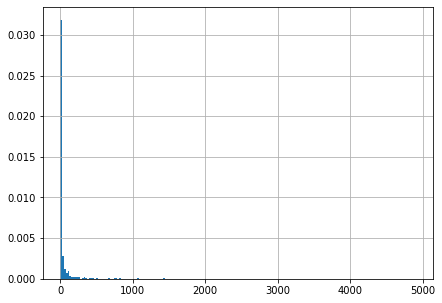

In [8]:
plt.figure(figsize=(7,5))
plt.hist(list(occ_freq.values()), bins=200, density=True)
plt.grid()
plt.show()

In [9]:
def filter_occs(x):
    ids = defaultdict(list)
    for i, occ_ids in enumerate(x["occupation_ids"]):
        ids[i] = []
        if occ_ids is not None:
            for j, occs in enumerate(occ_ids):
                if (occs is not None) and (occ_freq[occs] > 1):
                    ids[i].append(j)
    for i, elem in ids.items():
        if elem:
            x["occupation_ids"][i] = [e for j, e in enumerate(x["occupation_ids"][i]) if j in elem]
    return x
    
    

In [10]:
df = df.apply(lambda x: filter_occs(x), axis=1)

occ_set = set()
for occ_lsts in df["occupation_ids"].values:
    if occ_lsts is not None:
        for lst in occ_lsts:
            if lst is not None:
                occ_set.update(lst)
print(f"Reduced number of occupations: {len(occ_set)}")

Reduced number of occupations: 1024


> Next we will fiter Wikidata pages without `occupation` or `citizenship`. Also we will filter `genders` and `citizenship`, which does not match the `gender` and `citizenship` of majority

In [11]:
from collections import Counter

def filter_none(x):
    if len(x["gender"]) > 1:
        new_genders = []
        new_citizenship = []
        new_birth = []
        new_occupations = []
        
        gender_counter, citizenship_counter = Counter(x["gender"]), Counter(x["citizenship_id"])
        frequent_gender, _ = gender_counter.most_common()[0]
        if (frequent_gender == None) and len(gender_counter.most_common()) > 1:
            frequent_gender, _ = gender_counter.most_common()[1]
        
        frequent_citizenship, _ = citizenship_counter.most_common()[0]
        if (frequent_citizenship == None) and len(citizenship_counter.most_common()) > 1:
            frequent_citizenship, _ = citizenship_counter.most_common()[1]
        
        for i, (g, c) in enumerate(zip(x["gender"], x["citizenship_id"])):
            if (g == frequent_gender) and \
               (c == frequent_citizenship) and \
               ((x["birth"][i] is not None) and (int(x["birth"][i][1:5]) >= 1900)):
                new_genders.append(g)
                new_citizenship.append(c)
                new_birth.append(x["birth"][i][1:11])
                new_occupations.append(x["occupation_ids"][i])
        x["birth"], x["occupation_ids"], x["gender"], x["citizenship_id"] = new_birth, new_occupations, new_genders, new_citizenship
    return x
                
            

In [12]:
df = df.apply(lambda x: filter_none(x), axis=1)
df = df[~df.apply(lambda x: not(x["gender"] or x["birth"] or x["occupation_ids"] or x["citizenship_id"]), axis=1)]
percent = (df["citizenship_id"].apply(len) > 1).sum() / len(df)
print(f"Percent of quotations in dataset, where more then one QID is joined {percent}")

Percent of quotations in dataset, where more then one QID is joined 0.17201815930664466


In [14]:
df["gender"] = df["gender"].apply(lambda x: x[0])
df["citizenship_id"] = df["citizenship_id"].apply(lambda x: x[0])

In [15]:
multi = df[df["occupation_ids"].apply(lambda x: len(x)) > 1]
multi[multi["occupation_ids"].apply(
    lambda x: any(
        "sport" in [occupations_dict.get(e, None) for e in elem] 
        for elem in x if elem is not None
    )
)]

,q,d,s,o,gender,birth,occupation_ids,citizenship_id
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,anthony anderson,1,male,"[1981-11-12, 1970-08-15, 1956-09-27]","[[Q3665646], [Q245068, Q10800557, Q10798782, Q...",Q30
6,im a bit concerned but ive got everything in p...,2008-10-08 06:41:35,david nelson,2,male,"[1943-06-12, 1936-10-24, 1962-04-07, 1986-11-0...","[[Q639669, Q855091], [Q2526255, Q33999, Q10800...",Q30
23,last year was a hard year for us for people th...,2008-09-11 22:35:44,martin jensen,1,male,"[1946-12-16, 1983-10-02, 1978-07-27, 1991-09-2...","[[Q482980], [Q15306067], [Q937857], [Q130857, ...",Q35
30,some people are a bit concerned about it but p...,2008-12-25 03:53:33,richard jones,1,male,"[1969-04-26, 1979-04-06, 1978-09-12]","[[Q937857, Q628099], [Q855091, Q584301, Q63966...",Q145
31,that meant no record deals no big crowds no bi...,2008-12-11 15:03:48,david gillespie,1,male,"[1957-12-20, 1964-03-22]","[[Q82955, Q19280221], [Q14373094]]",Q408
...,...,...,...,...,...,...,...,...
25045,we do believe that there is something tangible...,2017-12-08 14:35:00,jim reid,1,male,"[1950-12-01, 1945-08-03]","[[Q19204627], [Q3665646]]",Q30
25052,this super conference is about bringing togeth...,2017-10-27 02:20:17,richard jacobs,2,male,"[1925-06-16, 1956-01-01]","[[Q43845], [Q5716684, Q133485, Q2490358]]",Q30
25053,we are able to connect the dots between bitcoi...,2017-05-13 00:00:00,james smith,4,male,"[1953-04-03, 1988-01-16, 1931-11-20]","[[Q11338576], [Q13474373], [Q2066131]]",Q30
25057,most people believe that bitcoin is not a secu...,2017-12-02 01:07:00,jay clayton,5,male,"[1951-07-11, 1966-07-11, 1951-07-11]","[[Q4263842, Q1930187, Q1650915], [Q40348], [Q4...",Q30


In [16]:
df['publish_year'] = df['d'].apply(lambda x: x[:4])
df['publish_month'] = df['d'].apply(lambda x: x[5:7])

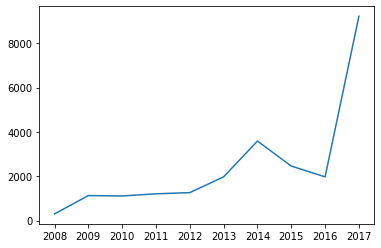

In [17]:
plt.plot(df.groupby('publish_year')['q'].count())
plt.show()

In [18]:
df.groupby(['publish_month', 'publish_year'])['q'].count()

publish_month  publish_year
01             2009              59
               2010             103
               2011             121
               2012              84
               2013              90
                               ... 
12             2013             325
               2014             212
               2015             321
               2016             320
               2017            2194
Name: q, Length: 112, dtype: int64

---

#### We can see 2 noticeable peaks, in 2014 and 2017. We want to understand the following things

- who (by occupation) was talking about the ctyptocurrencies/bitcoins/etc throughout the years
- first thing we want to understand is: why peaks are exactly in those years. What happened there that made such a peak 

In [19]:
df.groupby(['publish_year', 's'])['q'].count().sort_values(ascending=False)

publish_year  s                   
2017          jamie dimon             141
              charlie lee             130
              tom lee                  88
              vitalik buterin          79
2011          charlie sheen            74
                                     ... 
2013          adrienne hunt             1
              ahto buldas               1
              aidan o'shea              1
              ajit pai                  1
2017          zooko wilcox-o'hearn      1
Name: q, Length: 12294, dtype: int64

#### Now we need to find same names and occupancies (...)

In [20]:
occ_lst = list(occ_set)

G = networkx.Graph()
G.add_nodes_from(occ_lst)

edges = []
for o_i in occ_lst:
    for o_j in occ_lst:
        if fuzz.partial_ratio(occupations_dict[o_i], occupations_dict[o_j]) > 90:
            edges.append((o_i, o_j))
G.add_edges_from(edges)

In [21]:
cliques = list(networkx.find_cliques(G))
cliques_text = list(list(map(lambda x: occupations_dict[x], c)) for c in cliques)

In [22]:
for l in cliques_text:
    if 50 >= len(l) > 2:
        print(l)

['general manager', 'manager', 'manager', 'general manager', 'manager']
['television director', 'director', 'rector', 'director']
['security consultant', 'computer security consultant', 'consultant']
['artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'artist', 'diarist', 'artist', 'artist', 'artist', 'artist', 'artist']
['earth scientist', 'public health scientist', 'scientist']
['video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game']
['hedge fund manager', 'manager', 'fund manager', 'manager', 'manager']
['teacher', 'school teacher', 'high school teacher']
['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor',

In [23]:
# https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(cliques):
    G = networkx.Graph()
    for cli in cliques:
        G.add_nodes_from(cli)
        G.add_edges_from(to_edges(cli))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current
    

In [24]:
G = to_graph(cliques)

simmilar_occupasions = list(connected_components(G))
SIMILAR_OCCUPATIONS_DICT = {i: set(map(lambda x: occupations_dict[x], c)) for i,c in enumerate(simmilar_occupasions)}

In [25]:
def find_occupation_group(occupation):
    for i, group_occupations in SIMILAR_OCCUPATIONS_DICT.items():
        if occupation in group_occupations:
            return i

In [26]:
SIMILAR_OCCUPATIONS_DICT

{0: {'bodyguard'},
 1: {'harpist'},
 2: {'music promoter', 'promoter'},
 3: {'gentry'},
 4: {'film producer'},
 5: {'drag queen'},
 6: {'bank manager',
  'campaign manager',
  'fund manager',
  'general manager',
  'hedge fund',
  'hedge fund manager',
  'hotel manager',
  'manager',
  'talent manager',
  'team manager',
  'theatre manager'},
 7: {'serial killer'},
 8: {'clerk', 'law clerk'},
 9: {'hacker'},
 10: {'mayor'},
 11: {'cryptologist'},
 12: {'pensioner'},
 13: {'investor'},
 14: {'ophthalmologist'},
 15: {'organist'},
 16: {'assyriologist'},
 17: {'banker', 'investment banker'},
 18: {'soldier'},
 19: {'documentary filmmaker', 'filmmaker'},
 20: {'archaeologist', 'classical archaeologist'},
 21: {'acrobatic gymnast'},
 22: {'musical instrument maker'},
 23: {'stockbroker'},
 24: {'landscape painter', 'painter', 'portrait painter'},
 25: {'diplomat'},
 26: {'bass guitarist', 'classical guitarist', 'guitarist', 'jazz guitarist'},
 27: {'ornithologist'},
 28: {'lichenologist'},

---

##### Now we can group by occupation category

In [25]:
df.groupby('occupation_first_group')['q'].count().sort_values(ascending=False).head(7)

KeyError: 'occupation_first_group'

In [ ]:
SIMILAR_OCCUPATIONS_DICT[112], SIMILAR_OCCUPATIONS_DICT[114]

---

In [ ]:
a = df.groupby(['year'], as_index=False)

In [ ]:
for group in a.groups:
    print('----', group, '----')
    print(a.get_group(group).groupby('occupation_first_group').count().nlargest(5, 'q')['q'])

In [ ]:
def select_first_from_list(values, depth=1) -> list:
    temp_values = list('None' if v == [] else v[0] for v in values)
            
    if depth == 1:
        return temp_values
    else:
        return select_first_from_list(temp_values, depth=depth-1)

df['citizenship_first'] = select_first_from_list(values=df['citizenship'])
df['occupation_first'] = select_first_from_list(values=df['occupations'], depth=2)
df['gender_first'] = select_first_from_list(values=df['gender'])
df['birth_first'] = select_first_from_list(values=df['birth'])

del df["occupation_ids"]
del df["citizenship_id"]
del df["id"]
df.head()

In [ ]:
def change_occupancy_ids_to_names(values: list, dicitonary: dict) -> list:
    """
    :param: values - list of lists of ids
    :param: dicitonary - dictionary for id - name matching
    
    return list strings with union of all possible occupancies for a person
    """
    ans = []
    for quote_array in values:
        person_values = []
        for wikipage_array in quote_array:
            values_ = []
            if wikipage_array is None or len(wikipage_array) == 0:
                values_.append("None")
            else:
                for value_id in wikipage_array:
                    values_.append(dicitonary[value_id])
            person_values.append(values_)
        ans.append(person_values)
        
    return ans

df['occupations'] = change_occupancy_ids_to_names(df.occupation_ids, occupations_dict)
df['citizenship'] = df['citizenship_id'].apply(lambda x: list(None if not c else countries_dict[c] for c in x))

In [ ]:
multi = df[df["occupations"].apply(lambda x: len(x)) > 1]
multi[multi["occupations"].apply(lambda x: any("sport" in elem for elem in x))]

In [ ]:
df['occupation_first_group'] = df['occupation_first'].apply(lambda x: find_occupation_group(x))

In [ ]:
len(df['occupation_first'].unique()), len(df['occupation_first_group'].unique())